# Introduction and Background

In this notebook, we demonstrate how use CUR matrix decomposition to provide a low-rank approximation for a matrix. [(Mahoney 2009)](https://doi.org/10.1073/pnas.0803205106), [(Wikipedia)](https://en.wikipedia.org/wiki/CUR_matrix_approximation)

As should not be surprising at this point, for each model, we first go step-by-step through the derivation, with equations, embedded links, and citations supplied where useful. Lastly, we employ a "Utility Class" for the model, which is found in the utilities folder and contains all necessary functions.

In [243]:
#!/usr/bin/env python3
import sys
import time

# Maths things
import numpy as np
import scipy.sparse as sps

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm

# Progress Bar
from tqdm import tqdm_notebook as tqdm

# Local Utilities for Notebook
sys.path.append('../')
from utilities.general import FPS, load_variables, sorted_eig
from utilities.plotting import (
    plot_simple,
    plot_projection, plot_regression, check_mirrors, 
    get_cmaps, table_from_dict
)
from utilities.classes import PCA, LR
from utilities.CUR import CUR, approx_A, compute_P, get_Ct
                                                                                                                                                                                        
cmaps = get_cmaps()
plt.style.use('../utilities/kernel_pcovr.mplstyle')
dbl_fig=(2*plt.rcParams['figure.figsize'][0], plt.rcParams['figure.figsize'][1])

First, we must load the data. For a step-by-step explanation of this, please see [Importing Data](X_ImportingData.ipynb).

In [196]:
var_dict = load_variables(n_FPS=None)
locals().update(var_dict)

20  frames in total.
Shape of Input Data is  (2872, 2520) .
Splitting Data Set


# Fundamentals of CUR

PCA makes it possible to identify the directions of maximal variance of a dataset. Finding a projection of a new point along those coordinates, however, requires computing all the features in the initial description of the problem.


CUR decomposition, instead, attempts to find a low-[rank](https://en.wikipedia.org/wiki/Rank_(linear_algebra)) approximation of the feature matrix that is computed without having to evaluate every feature, or without using every point in the data set. Usually the matrices that enter the decomposition are labelled $\mathbf{C}$, $\mathbf{U}$, and $\mathbf{R}$, with reference to columns and rows of the initial matrix. To avoid naming conflicts with other matrices used in the rest of the tutorial, for a given matrix $\mathbf{A}$, we use the subscripts $c$ and $r$ to denote the matrices constructed out of the _columns_ and _rows_ of $\mathbf{A}$, and $\mathbf{S}$ for the a rectangular matrix determined by $\mathbf{A}_c$ and $\mathbf{A}_r$. In other words, $\mathbf{C}\to\mathbf{A}_c$, $\mathbf{R}\to\mathbf{A}_r$, and $\mathbf{U}\to\mathbf{S}$ and

\begin{equation}
\mathbf{A} \approx \tilde{\mathbf{A}} \equiv \mathbf{A}_c \mathbf{S} \mathbf{A}_r,
\end{equation}

Many strategies have been proposed to choose the best columns and rows. We summarize a variation on the theme that was introduced in [(Imbalzano 2018)](https://doi.org/10.1063/1.5024611), that is comparatively time consuming, but deterministic and  efficient in reducing the number of features needed to approximate $\mathbf{A}$. 

For this exercise, we compute the CUR decomposition of our training set $\mathbf{X}$. 
Because we later use CUR to choose features, we omitted the step of furthest point sampling in loading our data.

In [197]:
X_train.shape

(1436, 2520)

## Choosing the Columns

The CUR algorithm we implement modifies in-place the feature matrix. For this reason, we use a copy to perform the column selection

In [269]:
nCUR = 50
X_copy = X_train.copy()

The $c$ columns and $r$ rows are chosen based upon their "influence" on the overall matrix. We compute this "influence" using a **normalized statistical leverage score** $\pi$  computed from the [**singular value decomposition**](https://en.wikipedia.org/wiki/Singular_value_decomposition): $\mathbf{X} = \mathbf{U}_K\mathbf{\Sigma U}_C^T$, where $\mathbf{U_K}$ and $\mathbf{U_C}$ are the right and left principal components, respectively, and coincide with the eigenvectors of the Gram matrix $\mathbf{K} = \mathbf{XX}^T$ and the covariance $\mathbf{C} = \mathbf{X}^T\mathbf{X}$, also respectively. $\mathbf{\Sigma}$ is a rectangular-diagonal matrix with the singular values, which equal the square roots of the non-zero eigenvalues of both $\mathbf{C}$ or $\mathbf{K}$. 

In [199]:
%time
(U_K, sig, U_C) = np.linalg.svd(X_copy)

CPU times: user 30 µs, sys: 10 µs, total: 40 µs
Wall time: 13.4 µs


it helps (depending on the size of the matrix!) to use the sparse SVD from scipy.sparse to compute only $k$ components of the SVD, where $k$ is the target rank.

In [200]:
k=1

%time
(U_K, sig, U_C) = sps.linalg.svds(X_copy,k)

CPU times: user 26 µs, sys: 8 µs, total: 34 µs
Wall time: 13.6 µs


For the $j^{th}$ column, the importance score is given by

\begin{equation}
\pi_j = \frac{1}{k}\sum_i^k (U^{(ij)}_C)^2,
\end{equation}

where $k$ is again the target rank of the new matrix and $U^{(ij)}_C$ is the value in the $i^{th}$ row and $j^{th}$ column of $\mathbf{U}_C$.

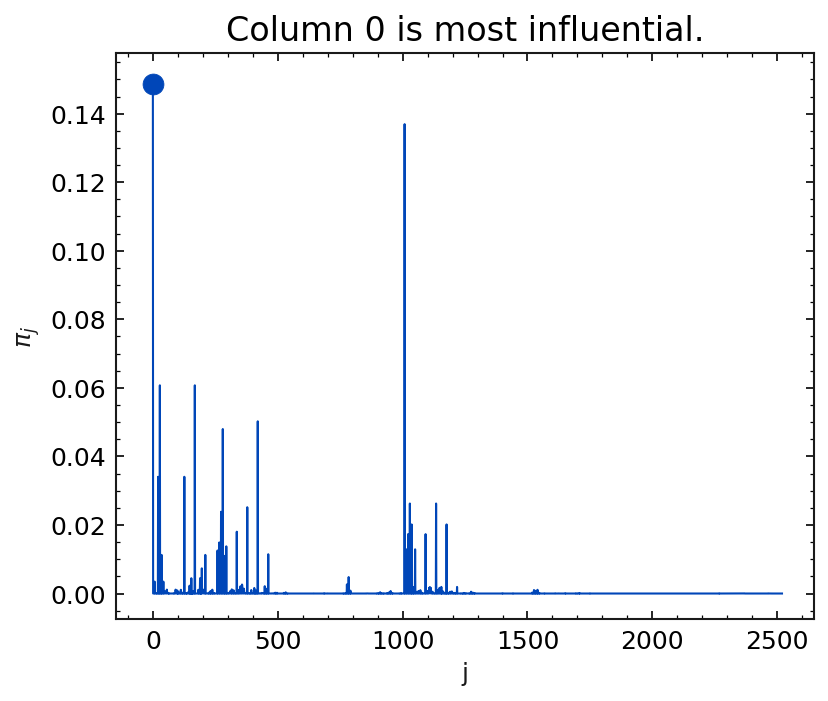

In [201]:
pi = (U_C[:k]**2.0).sum(axis=0)
j = pi.argmax()

plt.plot(pi)
plt.scatter(j, max(pi))
plt.xlabel("j")
plt.ylabel(r"$\pi_j$")
plt.title(f"Column {j} is most influential.")
plt.show()

## Orthogonalizing the Rest of the Columns

Most CUR algorithms select elements in a stochastic manner based on the statistical leverage score. Here we select in a deterministic manner the most influential feature. 
After choosing one column, we must orthogonalize the remaining $j'$ columns with respect to the $j^{th}$ column that has just been removed. This way we make sure that redundant entries won't be chosen over and over.

\begin{equation}
X_{kj'} = X_{kj'} - X_{kj}\left(\frac{\mathbf{X}_j\cdot \mathbf{X}_{j'}}{\mathbf{X}_j\cdot \mathbf{X}_{j}}\right).
\end{equation}

In [202]:
v = X_copy[:,j]/np.sqrt(np.matmul(X_copy[:, j],X_copy[:, j]))

for i in range(X_copy.shape[1]):
    X_copy[:,i] -= v * np.dot(v,X_copy[:,i])

we can repeat the procedure several times, until we've collected enough entries

In [203]:
idxs = [j]

for n in tqdm(range(nCUR-1)):
    (U_K, sig, U_C) = sps.linalg.svds(X_copy,k)
    pi = (U_C[:k]**2.0).sum(axis=0)
    idxs.append(pi.argmax())
    
    v = X_copy[:,idxs[-1]]/np.sqrt(np.matmul(X_copy[:, idxs[-1]],X_copy[:, idxs[-1]]))

    for i in range(X_copy.shape[1]):
        X_copy[:,i] -= v * np.dot(v,X_copy[:,i])
        

Now we have our column indices and construct $\mathbf{X}_C$.

In [204]:
idxs = np.asarray(idxs)

X_c = X_train[:, idxs]
X_c.shape

(1436, 50)

## Choosing the Rows
If the matrix we are decomposing is symmetric, we can use the same indices for the columns and rows. If it is non-symmetric (such as $\mathbf{X}$ is here), the $r$ most influential rows are found by computing the $r$ most influential columns of the transpose of the matrix

In [205]:
idxs_r = []
X_T = X_train.copy().T

for n in tqdm(range(nCUR)):
    (U_K, sig, U_C) = sps.linalg.svds(X_T,k)
    pi = (U_C[:k]**2.0).sum(axis=0)
    idxs_r.append(pi.argmax())
    
    v = X_T[:,idxs_r[-1]]/np.sqrt(np.matmul(X_T[:, idxs_r[-1]],X_T[:, idxs_r[-1]]))

    for i in range(X_T.shape[1]):
        X_T[:,i] -= v * np.dot(v,X_T[:,i])

X_r = X_train[idxs_r]        

## Constructing the Approximation

One determines $\mathbf{S}$ by computing the pseudoinverse of $\mathbf{X}_c$ and $\mathbf{X}_r$,

\begin{equation}
\mathbf{S}  = \mathbf{X}_c^- \mathbf{X} \mathbf{X}_r^- =  (\mathbf{X}_c^T \mathbf{X}_c)^{-1} \mathbf{X}_c^T \mathbf{X}(\mathbf{X}_r^T\mathbf{X}_r)^{-1}  \mathbf{X}_r^T .
\end{equation}

In [206]:
S_c = np.linalg.pinv(X_c)
S_r = np.linalg.pinv(X_r)

S = np.matmul(S_c, np.matmul(X_train, S_r))

The approximate $\mathbf{\tilde{X}}$ is the same shape as $\mathbf{X}$, but is low-rank. 

In [207]:
Xt = np.matmul(X_c, np.matmul(S, X_r))

print(np.linalg.matrix_rank(Xt), 
      np.linalg.matrix_rank(X_train))

50 1411


... and approximates $\mathbf{X}$, in a way that can be improved by increasing the number of rows and columns

In [208]:
np.linalg.norm(Xt - X_train)/np.linalg.norm(X_train)

0.30760276599730035

# CUR for Feature Selection

If one chooses to use CUR to select columns/features (analogous to how we have used FPS), the row matrix $\mathbf{X}_r$ is just the full $\mathbf{X}$, and so one determines $\mathbf{S}$ by computing the pseudoinverse of $\mathbf{X}_c$ and $\mathbf{X}$,
\begin{equation}
\mathbf{S}  = \mathbf{X}_c^- \mathbf{X} \mathbf{X}^-
=(\mathbf{X}_c^T \mathbf{X}_c)^{-1} \mathbf{X}_c^T \mathbf{X} (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T.
\end{equation}

In [209]:
S_c = np.linalg.pinv(X_c)
S_X = np.linalg.pinv(X_train)

S = np.matmul(S_c, np.matmul(X_train, S_X))

Xt_raw = np.matmul(X_c, np.matmul(S, X_train))

For feature selection $\tilde{\mathbf{X}}$ reduces to:

\begin{align}
\tilde{\mathbf{X}} &= \mathbf{X}_c(\mathbf{X}_c^T \mathbf{X}_c)^{-1} \mathbf{X}_c^T \mathbf{X} (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T\mathbf{X}\\
\tilde{\mathbf{X}} &= \mathbf{X}_c(\mathbf{X}_c^T \mathbf{X}_c)^{-1} \mathbf{X}_c^T \mathbf{X}
\end{align}

so $\mathbf{S}$ is instead computed as

\begin{equation}
\mathbf{S} = (\mathbf{X}_c^T \mathbf{X}_c)^{-1} \mathbf{X}_c^T
\end{equation}

In [210]:
S = np.linalg.pinv(X_c)
Xt = np.matmul(X_c, np.matmul(S, X_train))

In [211]:
np.linalg.norm(Xt_raw - Xt)

1.0442981366296937e-11

We use the utility `approx_A(X_train, idx)` in `utilities/CUR.py` to do this process from now on. 

With this dataset (but not all datasets), CUR minimizes the loss compared to FPS, especially for small numbers of columns.

In [212]:
ns = np.array([int(10**x) for x in np.linspace(1, np.log10(nCUR),20)])
ifps = FPS(X_train.T, n)[0]

X_CUR = [approx_A(X_train, idxs[:n]) for n in ns]
X_FPS = [approx_A(X_train, ifps[:n]) for n in ns]

err_CUR = np.array([np.linalg.norm(X_train - Xt)/np.linalg.norm(X_train) for Xt in X_CUR])
err_FPS = np.array([np.linalg.norm(X_train - Xt)/np.linalg.norm(X_train) for Xt in X_FPS])

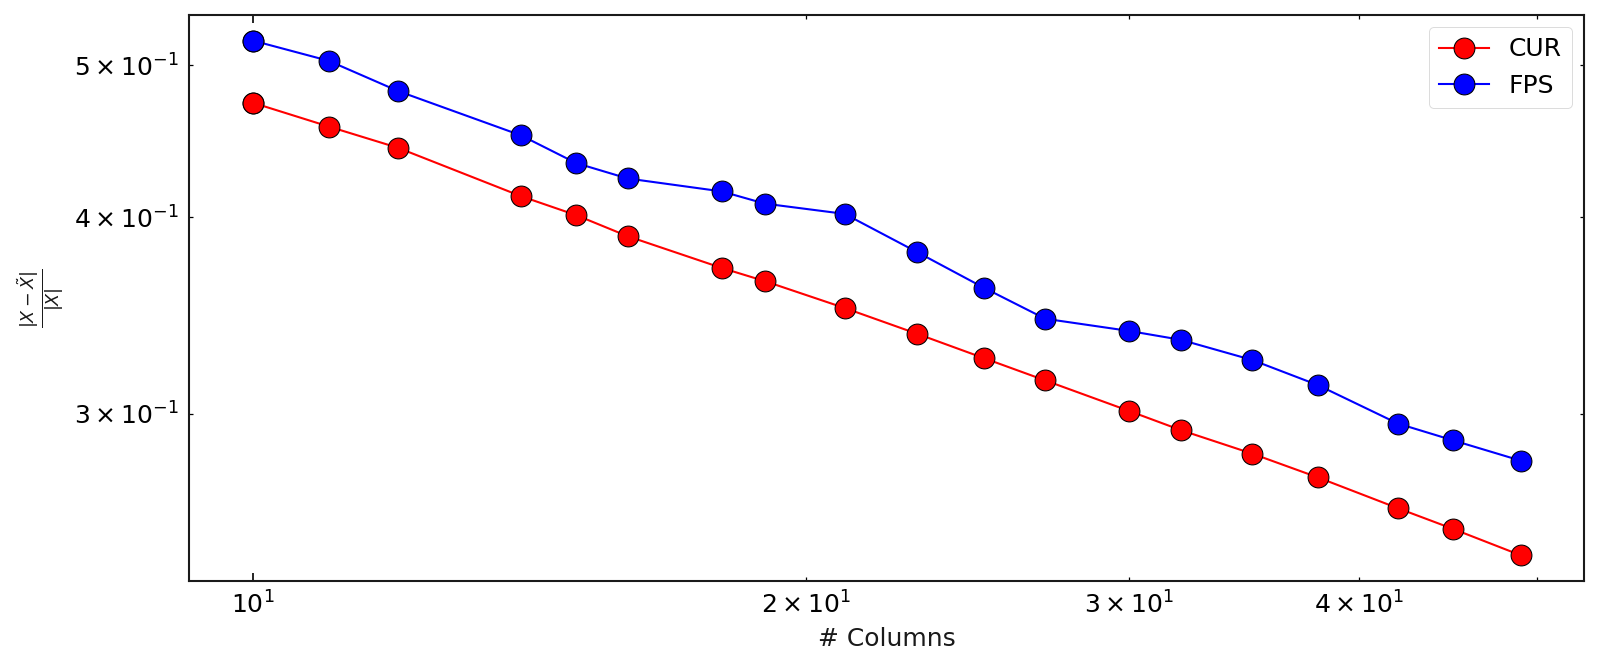

In [213]:
fig, ax = plt.subplots(1, figsize=dbl_fig)

plt.loglog(ns, err_CUR, marker='o', label="CUR", c='r' )
plt.loglog(ns, err_FPS, marker='o', label="FPS", c='b' )

ax.set_xlabel('# Columns')
ax.set_ylabel(r"$\frac{|X-\tilde{X}|}{|X|}$")
plt.legend()
plt.show()

# Using the Approximation in ML Models

## Projecting into Latent Space

Whenever the features are used to approximate distances or scalar products, it is possible to obtain a $n_{samples}\times n_{CUR}$ reduced feature matrix $\mathbf{T} = \mathbf{X}_c \mathbf{P}_{X_c T}$ that yields the exact same values as when using the approximate $\tilde{\mathbf{X}}$. For the sake of brevity, we abbreviate $\mathbf{P}_{X_c T}$ to $\mathbf{P}_c$.


<!---**Logic 1** We start with the equation for projecting $\mathbf{X}$ into latent space via PCA:

\begin{equation}
\mathbf{T} = \mathbf{X}\hat{\mathbf{U}}_{C}
\end{equation}

where $\mathbf{C} = \mathbf{X}^T\mathbf{X}$, and $\mathbf{U}_C$ is truncated to some value of $n_{PCA}$. We replace $\mathbf{X}$ with its feature-selected approximation $\tilde{\mathbf{X}}$:

\begin{equation}
\mathbf{T} = \mathbf{X}_c\mathbf{SX}_r\mathbf{U}_{C}.
\end{equation}

Therefore $\mathbf{P}_{c} = \mathbf{SX}_r\hat{\mathbf{U}}_{C}$. To avoid explicitly calculating $\mathbf{U}_{C}$, we instead take advantage of its orthogonality and solve for $\mathbf{P}_{c}$ from

\begin{align}
\mathbf{P}_{c}\mathbf{P}_{c}^T &=\mathbf{SX}_r\mathbf{U}_{C}\mathbf{U}_{C}^T\mathbf{X}_r^T\mathbf{S}^T\\
&=\mathbf{SX}_r\mathbf{X}_r^T\mathbf{S}^T\\
\end{align} -->


The idea is to compute $\mathbf{T}$ such that $\mathbf{TT}^T$ is identical to $\mathbf{\tilde{X}\tilde{X}}^T$. Given the definition of $\mathbf{\tilde{X}}$, we get 

\begin{equation}
\mathbf{\tilde{X}\tilde{X}}^T$ = \mathbf{X}_c\mathbf{SX}_r\mathbf{X}_r^T\mathbf{S}^T\mathbf{X}_c^T=
\mathbf{X}_c \mathbf{P}_c\mathbf{P}_c^T \mathbf{X}_c^T
\end{equation}


Which yields the symmytric solution

\begin{equation}
\mathbf{P}_{c} = \left[ \mathbf{SX}_r\mathbf{X}_r^T\mathbf{S} \right]^{1/2}. \label{eq:cur-t}
\end{equation}

The $n_{CUR} \times n_{CUR}$ matrix $\mathbf{P}_{c}$ is computed once and re-used every time one needs to compute $\mathbf{T}$ for new samples. 

In [214]:
S_c = np.linalg.pinv(X_c)
S_r = np.linalg.pinv(X_r)

S = np.matmul(S_c, np.matmul(X_train, S_r))

SX = np.matmul(S, X_r)
SX = np.matmul(SX, SX.T) 

v_SX, U_SX = np.linalg.eigh(SX) 
v_SX[v_SX<1e-12] = 0

P_c = np.matmul(U_SX, np.diagflat(np.sqrt(v_SX)))

T = np.matmul(X_c, P_c)
T_test = np.matmul(X_test[:, idxs], P_c)

From now on, we use the  utility function `compute_P(X_c, S, X_r)` in `utilities/CUR.py` to do this. 

## Representation error

The CUR latent space approximates very well the principal components of the feature space. The eigenvalues of the latent-space covariance match those of the full covariance. Note also how the scaling by $\mathbf{P}_c$ of $\mathbf{X}_c$ improves dramatically the match.

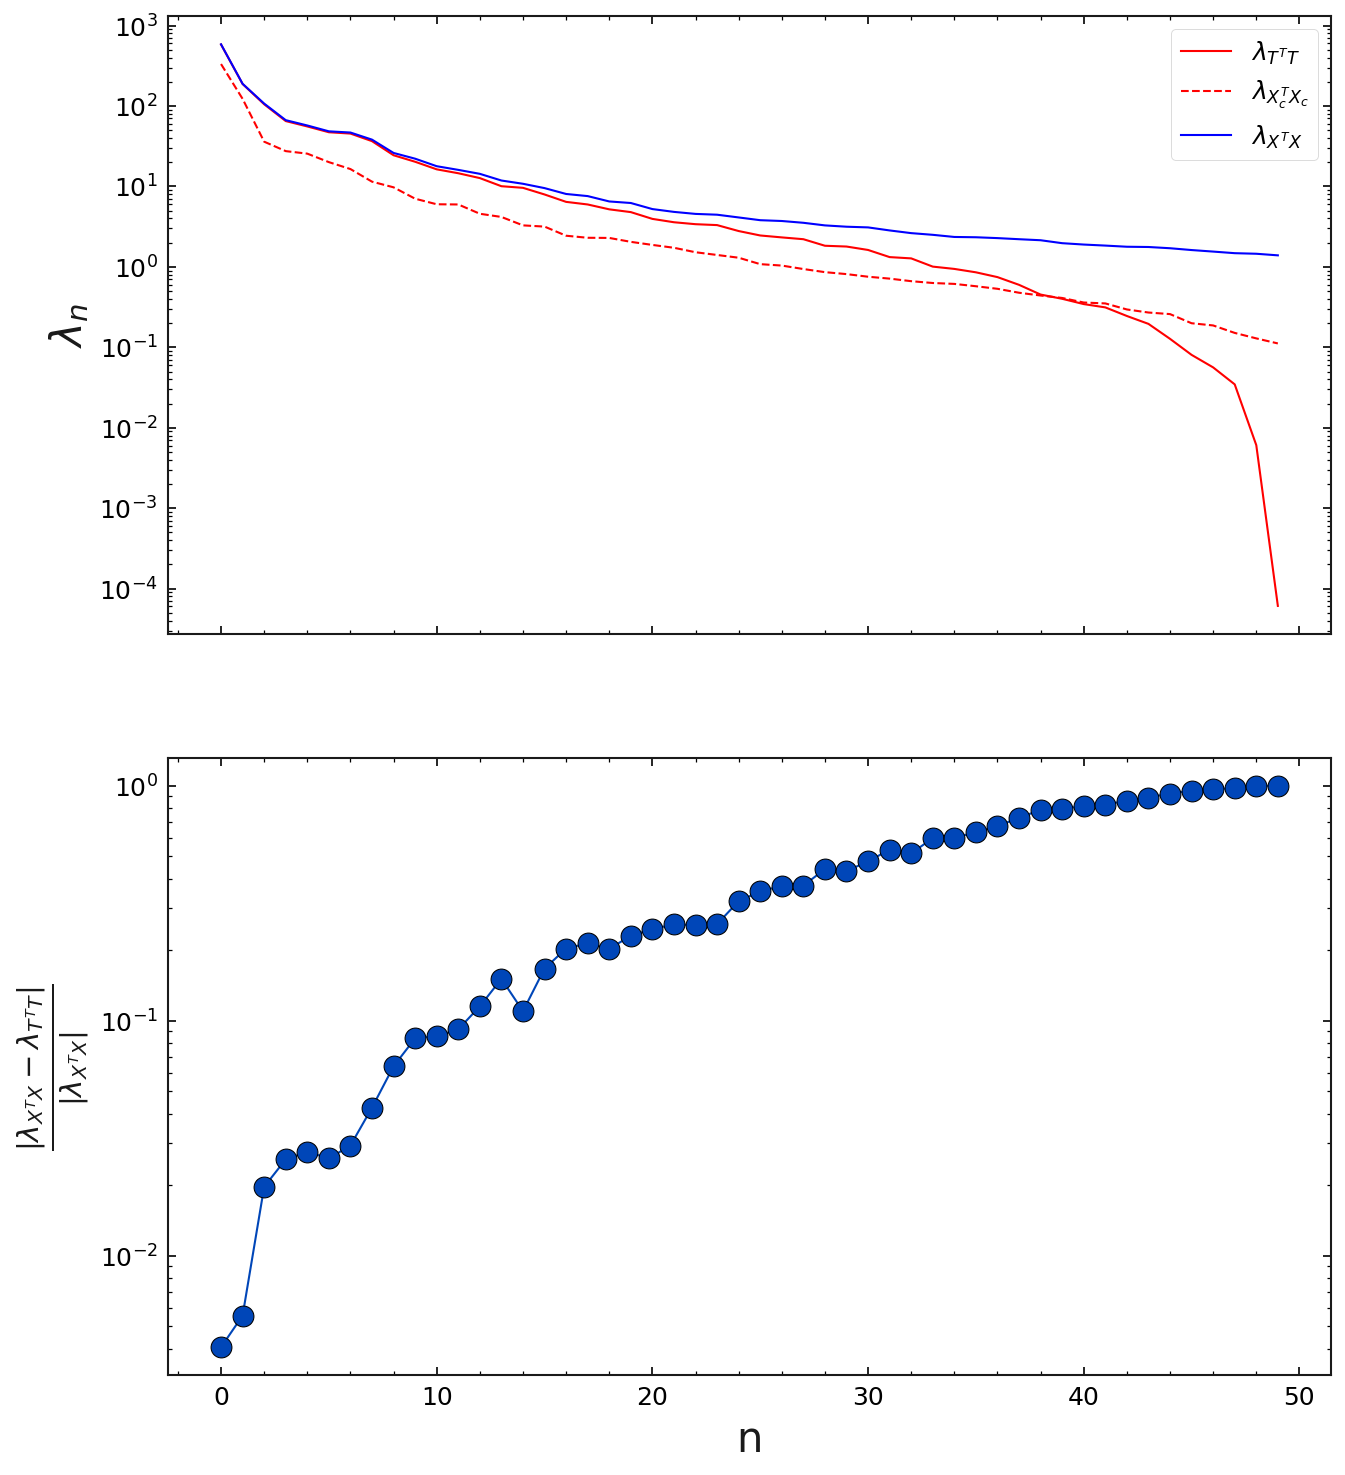

In [222]:
fig, ax = plt.subplots(2, sharex=True, figsize=(10,12))

eigTTT = np.array(list(reversed(np.linalg.eigvalsh(np.matmul(T.T,T)))))
eigXcTXc = np.array(list(reversed(np.linalg.eigvalsh(np.matmul(X_c.T,X_c))[-T.shape[1]:])))
eigXTX = np.array(list(reversed(np.linalg.eigvalsh(np.matmul(X_train.T,X_train))[-T.shape[1]:])))

ax[0].semilogy(eigTTT, 'r', label=r'$\lambda_{T^T T}$')
ax[0].semilogy(eigXcTXc, 'r--', label=r'$\lambda_{X_c^T X_c}$')
ax[0].semilogy(eigXTX, 'b', label=r'$\lambda_{X^T X}$')

ax[0].legend()
ax[0].set_ylabel(r"$\lambda_n$", fontsize=20)

error = [abs(t-a)/a for t,a in zip(eigTTT, eigXTX)]
ax[1].semilogy(error, marker='o')
ax[1].set_ylabel(r'$\frac{|\lambda_{X^T X}-\lambda_{T^T T}|}{|\lambda_{X^T X}|}$', fontsize=20)
ax[1].set_xlabel("n", fontsize=20)

plt.show()

A measure of error is given by the accuracy in representing the Gram matrix (the Torgenson loss)

In [228]:
print("Torgenson loss with raw column selection", 
      np.linalg.norm(np.matmul(X_train,X_train.T)-np.matmul(X_c,X_c.T)))
print("Torgenson loss with scaled, CUR latent space", 
      np.linalg.norm(np.matmul(X_train,X_train.T)-np.matmul(T,T.T)))

Torgenson loss with raw column selection 293.00509298813995
Torgenson loss with scaled, CUR latent space 30.883013961551992


## PCA Performance

Let's compare the projections and errors with the original $\mathbf{X}$ and the CUR feature-selected $\mathbf{\tilde{X}}$.

In [223]:
pca_high_rank = PCA(n_PCA=2)
pca_high_rank.fit(X_train)
T_high_rank = pca_high_rank.transform(X_test)

S = np.linalg.pinv(X_c)
P = compute_P(X_train[:, idxs], S, X_train)

# we find the CUR latent space for train and test
T_train = np.matmul(X_train[:, idxs], P)
T_test = np.matmul(X_test[:, idxs], P)

pca_low_rank = PCA(n_PCA=2)
pca_low_rank.fit(T_train)
T_low_rank = pca_low_rank.transform(T_test)

The projections based on the CUR selected figures reproduce well those based on the full dataset

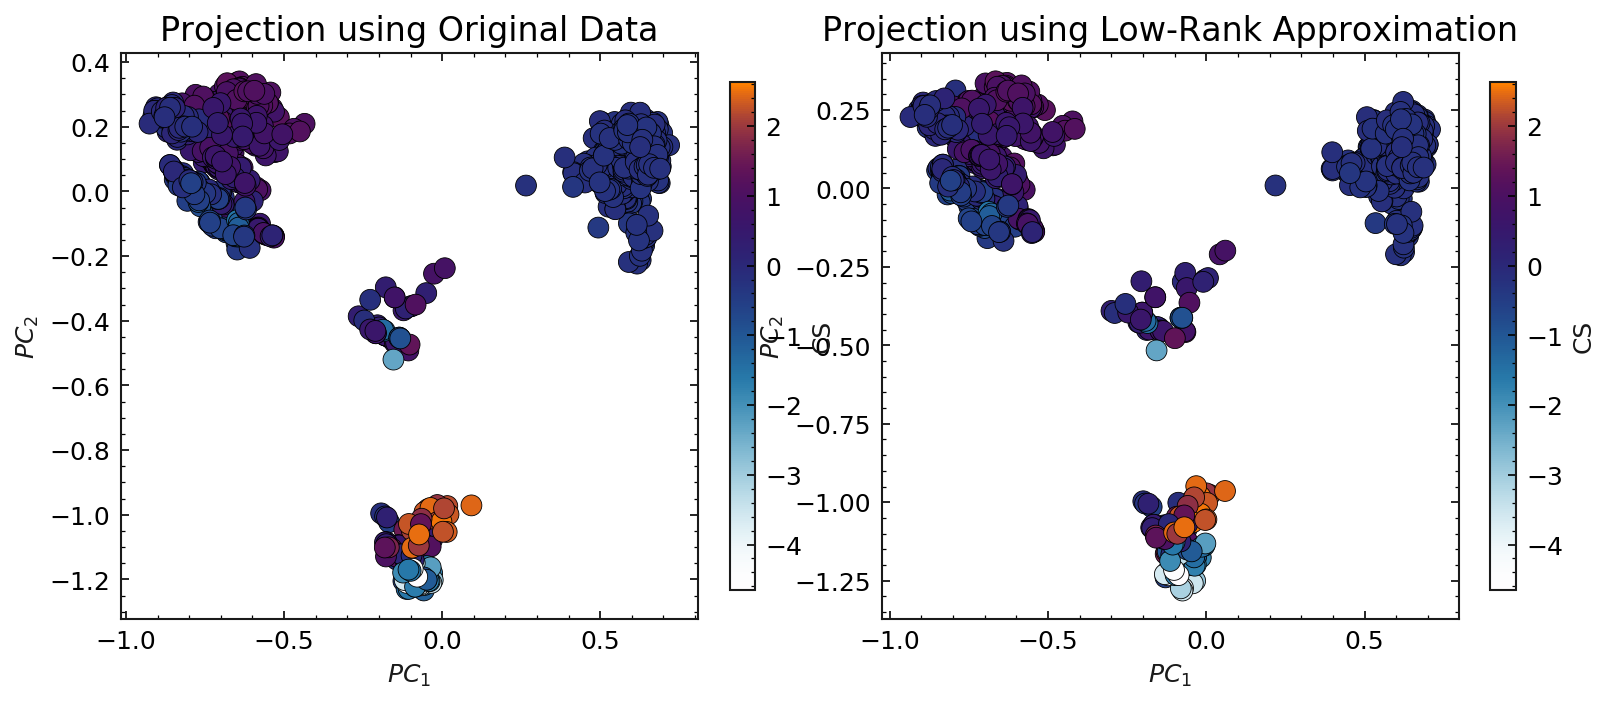

In [224]:
# plotting
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_projection(Y=Y_test, T=T_high_rank, fig=fig, ax=ax[0], 
                title="Projection using Original Data", 
                **cmaps)
plot_projection(Y=Y_test, T=check_mirrors(T_low_rank,T_high_rank), 
                fig=fig, ax=ax[1],  
                title="Projection using Low-Rank Approximation", 
                **cmaps)
plt.show()

PCA statistics are not particularly meaningful, because they report on the performance of PCA in representing the full or CUR-reduced feature space.

In [234]:
# statistics
table_from_dict([pca_low_rank.statistics(T_test),
                 pca_high_rank.statistics(X_test)
                 ],
                headers=["Low Rank", "High Rank"],
                title="Latent Space Projections"
               )

<center><b> Latent Space Projections </b></center><br>                            <center><table><tr><th></th><th><center>Low Rank</center></th><th><center>High Rank</center></th></tr><td> Dataset Variance<br>$\sigma_X^2$ </td>                                                <td> 0.94052 </td><td> 1.00103 </td></tr><tr><td> Projection Variance<br>$\sigma_T^2$ </td>                                                <td> 0.541512 </td><td> 0.542241 </td></tr><tr><td> Residual Variance<br>$\sigma_X^2 - \sigma_T^2$ </td>                                                <td> 0.399008 </td><td> 0.458791 </td></tr><tr><td> Representation Error </td>                                                <td> 0.399617 </td><td> 0.459461 </td></tr></table></center>

## LR Performance

It is more meaningful to compare the performance of a regression model built on the full $\mathbf{X}$ or on the latent CUR space

In [229]:
lr_high_rank = LR(regularization=1e-6)
lr_high_rank.fit(X_train, Y_train)
Ylr_high_rank = lr_high_rank.transform(X_test)

lr_low_rank = LR(regularization=1e-6)
lr_low_rank.fit(T_train, Y_train)
Ylr_low_rank = lr_low_rank.transform(T_test)

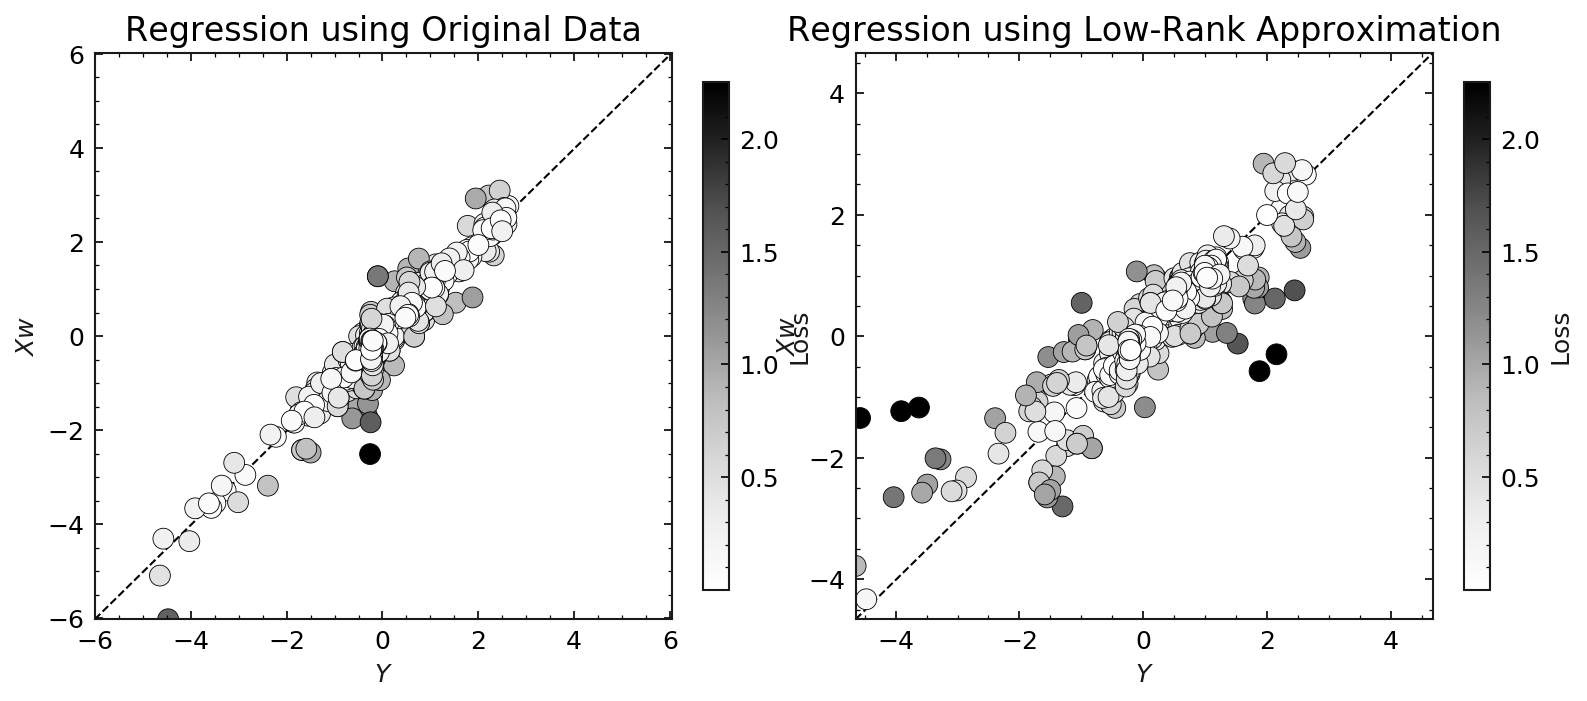

In [231]:
# plotting

fig, ax = plt.subplots(1,2, figsize=(12,5))

Yerr = np.abs(Y_test-Ylr_high_rank)
plot_regression(Y=Y_test[:,0], Yp=Ylr_high_rank[:,0], 
                fig=fig, ax=ax[0], 
                title="Regression using Original Data", 
                vmin=Yerr.min(), vmax=Yerr.max(),
                **cmaps)
plot_regression(Y=Y_test[:,0], Yp=Ylr_low_rank[:,0],
                fig=fig, ax=ax[1],  
                vmin=Yerr.min(), vmax=Yerr.max(),
                title="Regression using Low-Rank Approximation", 
                **cmaps)

plt.show()

In [232]:
# statistics
table_from_dict([lr_low_rank.statistics(T_test, Y_test),
                 lr_high_rank.statistics(X_test, Y_test)],
                headers=["Low Rank", "High Rank"],
                title="Property Regressions"
               )

<center><b> Property Regressions </b></center><br>                            <center><table><tr><th></th><th><center>Low Rank</center></th><th><center>High Rank</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.79658 </td><td> 0.897098 </td></tr><tr><td> Regression Error </td>                                                <td> 0.0122955 </td><td> 0.00874503 </td></tr></table></center>

## Need for Orthogonalizing

Now that we know how to compute the error of each approximation, we look at the importance of the orthogonalization procedure discussed in Sec. 2.2. 

Imagine we were to choose all of our columns at once, corresponding to the top $n_{CUR}$ features based on their leverage score.

In [235]:
(U_K, sig, U_C) = np.linalg.svd(X_train)
pi = (U_C[:k]**2.0).sum(axis=0)

idxs2 = np.flip(np.argsort(pi))[:nCUR]

First we compare the Gram matrix approximation performance

In [237]:
S2 = np.matmul(np.matmul(np.linalg.pinv(X_train[:, idxs2]), X_train), np.linalg.pinv(X_train))
P2 = compute_P(X_train[:, idxs2], S2, X_train)
T_train2 = np.matmul(X_train[:, idxs2], P2)
T_test2 = np.matmul(X_test[:, idxs2], P2)


print("Torgenson loss with one-off leverage score selection", 
      np.linalg.norm(np.matmul(X_train,X_train.T)-np.matmul(T_train2,T_train2.T)))

print("Torgenson loss with iterative orthogonalisation", 
      np.linalg.norm(np.matmul(X_train,X_train.T)-np.matmul(T_train,T_train.T)))

Torgenson loss with one-off leverage score selection 74.3460930335357
Torgenson loss with iterative orthogonalisation 29.282678222438584


And the linear regressions...

In [239]:
lr_2 = LR()
lr_2.fit(T_train2, Y_train)
T_2 = lr_2.transform(T_test2)

lr_1 = LR()
lr_1.fit(T_train, Y_train)
T = lr_1.transform(T_test)

# statistics
table_from_dict([lr_2.statistics(T_test2, Y_test), 
                lr_1.statistics(T_test, Y_test)],
                headers=["One-off selection", "Iterative Orthogonalisation"],
                title="Property Regressions"
               )

<center><b> Property Regressions </b></center><br>                            <center><table><tr><th></th><th><center>One-off selection</center></th><th><center>Iterative Orthogonalisation</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.599871 </td><td> 0.79658 </td></tr><tr><td> Regression Error </td>                                                <td> 0.0172444 </td><td> 0.0122955 </td></tr></table></center>

In both cases, the orthogonalized features perform considerably better than those chosen without orthogonalizing.

# PCov-CUR

## The New Leverage Scores

The PCovR formulation is particularly appealing to select a small number of ML features to be used for machine learning, because it allows incorporating information on the ability of different features to predict the target properties.
We propose to proceed as in Section 3, but to compute the leverage scores by computing the eigenvectors of the PCovR covariance matrix $\mathbf{\tilde{C}}$ in place of the singular value decomposition, given by 

\begin{equation}
\tilde{\mathbf{C}} = \alpha \mathbf{C}
    + (1 - \alpha)  \mathbf{C}^{1/2}\left(\mathbf{C}+\lambda \mathbf{I}\right)^{-1}\mathbf{X}^T{\mathbf{Y} \mathbf{Y}^T}\mathbf{X}\left(\mathbf{C}+\lambda \mathbf{I}\right)^{-1}\mathbf{C}^{1/2}
\end{equation}

where $\mathbf{C} = \mathbf{X}^T\mathbf{X}$. The best results are obtained by computing leverage scores using a number of eigenvectors that is smaller or equal than the number of properties in $\mathbf{Y}$. 

Because we have to calculate $\mathbf{\tilde{C}}$ iteratively, we use a utility function `get_Ct(X, Y, alpha)`

In [270]:
X_copy = X_train.copy()
Y_copy = Y_train.copy()

In [271]:
k = 1
alpha = 0.5
nCUR = 50
Ct = get_Ct(X_copy, Y_copy, alpha=alpha, regularization=1e-7)

In [272]:
v_Ct, U_Ct = sorted_eig(Ct)

pi = (U_Ct[:,:k]**2.0).sum(axis=1)
j = pi.argmax()

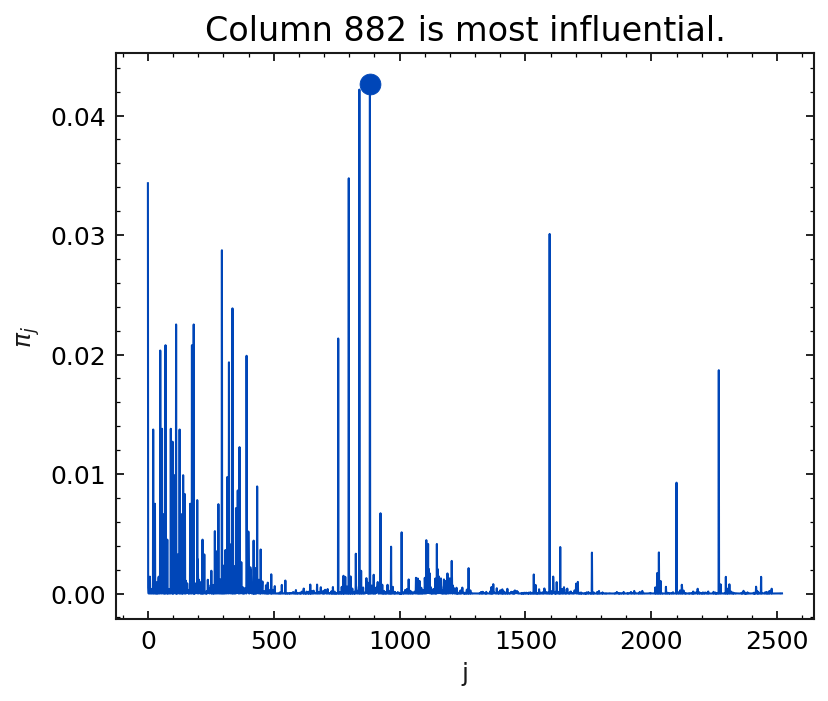

In [273]:
plt.plot(pi)
plt.scatter(j, max(pi))
plt.xlabel("j")
plt.ylabel(r"$\pi_j$")
plt.title(f"Column {j} is most influential.")
plt.show()

In [274]:
X_c = X_copy[:, [j]]

## Adjusting the Remaining Columns

The only additional change that needs to be incorporated in the procedure described in Sec. 2.2 involves eliminating at each step the components of the property matrix $\mathbf{Y}$ that is described by the features that have already been selected. Computing at each step the reduced vector $\mathbf{T} = \mathbf{X}_c\mathbf{P}_{c}$, one should perform the update 

\begin{equation}
    \mathbf{Y} = \mathbf{Y} - \mathbf{T} \left(\mathbf{T}^T \mathbf{T}\right)^{-1}\mathbf{T}^T \mathbf{Y}.
\end{equation}

Note that when the linear regression is performed without regularisation, the transformation from $\mathbf{X}_c$ to $\mathbf{T}$ is inconsequential (as it can be seen just by cancelling out instances of $\mathbf{P}_{c}$, which one can do when $\mathbf{P}_{c}$ is invertible and symmetric). We can then avoid the calculation of the projection matrix and simply do

\begin{equation}
    \mathbf{Y} = \mathbf{Y} - \mathbf{X}_c \left(\mathbf{X}_c^T \mathbf{X}_c\right)^{-1}\mathbf{X}_c^T \mathbf{Y}.
\end{equation}

In [275]:
S = np.linalg.pinv(X_c)

SX = np.matmul(S, X_copy)
SX = np.matmul(SX, SX.T) 

v_SX, U_SX = np.linalg.eigh(SX) 
v_SX[v_SX<1e-12] = 0

P_c = np.matmul(U_SX, np.diagflat(np.sqrt(v_SX)))

T = np.matmul(X_c, P_c)

See how the two vectors are the same

In [276]:
v1 = np.linalg.pinv(np.matmul(T.T, T))
v1 = np.matmul(T, v1)
v1 = np.matmul(v1, T.T)

v2 = np.linalg.pinv(np.matmul(X_c.T, X_c))
v2 = np.matmul(X_c, v2)
v2 = np.matmul(v2, X_c.T)
print(np.linalg.norm(v1-v2))

1.2349941505625556e-16


In [277]:
Y_copy -= np.matmul(v2, Y_copy)

Just like in Sec. 2.2, we must orthogonalize the remaining $j'$ columns in $\mathbf{X}$ with respect to the $j^{th}$ column that has just been removed.

\begin{equation}
X_{kj'} = X_{kj'} - X_{kj}\left(\frac{\mathbf{X}_j\cdot \mathbf{X}_{j'}}{\mathbf{X}_j\cdot \mathbf{X}_{j}}\right).
\end{equation}

In [278]:
v = X_copy[:,j]/np.sqrt(np.matmul(X_copy[:, j],X_copy[:, j]))

for i in range(X_copy.shape[1]):
    X_copy[:,i] -= v * np.dot(v,X_copy[:,i])

## Choosing the Remaining Columns

We then iterate until we've chosen the right number of columns (beware: this can be slow!)

In [279]:
idxs = [j]

for n in tqdm(range(nCUR-1)):
    
    try:
        Ct = get_Ct(X_copy, Y_copy, alpha=alpha)
    except:
        print(f"Only {n} features possible")
        break
        
    v_Ct, U_Ct = sorted_eig(Ct)
    
    pi = (U_Ct[:,:k]**2.0).sum(axis=1)
    
    j=pi.argmax()
    idxs.append(j)
    
    X_c = X_copy[:, idxs]
    v = np.linalg.pinv(np.matmul(X_c.T, X_c))
    v = np.matmul(X_c, v)
    v = np.matmul(v, X_c.T)

    Y_copy -= np.matmul(v, Y_copy)
    
    v = X_copy[:,j]/np.sqrt(np.matmul(X_copy[:, j],X_copy[:, j]))

    for i in range(X_copy.shape[1]):
        X_copy[:,i] -= v * np.dot(v,X_copy[:,i])

In [280]:
idxs = np.asarray(idxs)
idxs

array([ 882, 2268,  798,    0,  294, 1596, 1008,  392, 1764,  196,  924,
        546, 2184,  280,  322,  393,  147, 1274, 2037, 1533,  378,  395,
        352,  182,  770, 2058, 1638,  266,  861,  784,  897,  387,  735,
       1680,   84,  525,  401, 2030, 2100,  462, 2416, 1617, 2417, 1210,
       1204,  872, 2121,  819,  952,  870])

## LR Performance

We do the usual gig to find the CUR latent space

In [281]:
S = np.linalg.pinv(X_train[:,idxs])
P = compute_P(X_train[:, idxs], S, X_train)

# we find the CUR latent space for train and test
T_pcov = np.matmul(X_train[:, idxs], P)
T_pcov_test = np.matmul(X_test[:, idxs], P)


... and show how choosing columns with a PCovR-based leverage score improve substantially the regression performance (note that you must have run the previous cells in the notebook to see the stats from the vanilla CUR)

In [282]:
lr_pcov = LR(regularization=1e-6)
lr_pcov.fit(T_pcov, Y_train)
Ylr_pcov = lr_low_rank.transform(T_pcov_test)

In [283]:
# statistics
table_from_dict([lr_2.statistics(T_test2, Y_test), 
                lr_1.statistics(T_test, Y_test),
                lr_pcov.statistics(T_pcov_test, Y_test)],
                headers=["One-off selection", "Iterative Orthogonalisation", "PCov-CUR"],
                title="Property Regressions"
               )

<center><b> Property Regressions </b></center><br>                            <center><table><tr><th></th><th><center>One-off selection</center></th><th><center>Iterative Orthogonalisation</center></th><th><center>PCov-CUR</center></th></tr><td> Coefficient of Determination<br>($R^2$) </td>                                                <td> 0.599871 </td><td> 0.79658 </td><td> 0.891968 </td></tr><tr><td> Regression Error </td>                                                <td> 0.0172444 </td><td> 0.0122955 </td><td> 0.00896036 </td></tr></table></center>

# The Utility Classes

## CUR Framework

In [ ]:
from utilities.CUR import CUR

You provide the utility class with the variable ``precompute``, which tells the CUR how many columns it should pre-emptively store. This makes it eash to change the rank of the CUR.

In [ ]:
cur = CUR(X_train, precompute=nCUR)

In [ ]:
errors = [cur.loss(n, min(n, nCUR)) for n in tqdm(ns)]

In [ ]:
plot_simple(np.array([ns, errors]).T, **cmaps)
plt.xlabel(r"$n_{CUR}$", fontsize=20)
plt.ylabel(r"$\frac{\left| X - \tilde{X} \right|}{| X |}$", fontsize=20)
plt.show()

## Feature Selection 

If you want to use CUR for feature selection,  $\mathbf{\tilde{X}} = \mathbf{X}_c \mathbf{SX}$, you disable row selection.

In [ ]:
from utilities.CUR import CUR

In [ ]:
cur_fs = CUR(X_train, precompute=nCUR, feature_select=True)

In [ ]:
cur_fs.idx_r.shape

In [ ]:
error_fs = [cur_fs.loss(n) for n in tqdm(ns)]

In [ ]:
plot_simple(np.array([ns, error_fs]).T, **cmaps)
plt.xlabel(r"$n_{CUR}$", fontsize=20)
plt.ylabel(r"$\frac{\left| X - \tilde{X} \right|}{| X |}$", fontsize=20)
plt.show()

## PCov-CUR

In [266]:
from utilities.CUR import CUR

In [267]:
c = CUR(X_train, pi_function="pcovr", 
        precompute=int(max(ns)), 
        feature_select=True,
        params=dict(Y=Y_train, alpha=0.5))

KeyboardInterrupt: 

In [ ]:
error_pcovs = [c.loss(n) for n in tqdm(ns)]

In [ ]:
plot_simple(np.array([ns, error_pcovs]).T, **cmaps)
plt.xlabel(r"$n_{CUR}$", fontsize=20)
plt.ylabel(r"$\frac{\left| X - \tilde{X} \right|}{| X |}$", fontsize=20)
plt.show()